<a href="https://colab.research.google.com/github/MinaBeric/Hate-Speech-Detection-Text-Mining-and-Sentiment-Analysis/blob/main/Ihateyou%21_Text_Mining.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [ ]:
#Install and load all the libraries used
!pip install transformers==4.28.1
!pip install gensim
!pip install tensorflow_hub
!pip install tensorflow_text
!pip install keras_tuner
!pip install contractions
!pip install googletrans
!pip install datasets scikit-learn evaluate

import os
import re
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import product
import torch
import evaluate


import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag
import spacy
import contractions
from wordcloud import WordCloud
from textblob import TextBlob
from googletrans import Translator


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from keras_tuner import HyperModel, HyperParameters
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, SimpleRNN, Dropout,
    Dense, BatchNormalization, LSTM
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import gensim.downloader as api
from gensim.models import Word2Vec, FastText, KeyedVectors


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, f1_score, precision_score,
    recall_score, accuracy_score, classification_report,
    ConfusionMatrixDisplay
)


nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')


from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments,
    Trainer, EarlyStoppingCallback, DataCollatorWithPadding, get_scheduler
)

from datasets import load_dataset, Dataset






   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#For later use during model's implementation
def plot_training_history(history, epochs_range, title_prefix="Model"):

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch', size=12)
    plt.ylabel('Loss', size=12)
    plt.title(f'{title_prefix} Loss')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.0, 1.0)
    plt.legend(loc='lower right')
    plt.title(f'{title_prefix} Accuracy over epochs')

    plt.tight_layout()
    plt.show()

In [ ]:
!wget https://raw.githubusercontent.com/Vicomtech/hate-speech-dataset/master/annotations_metadata.csv



--2025-05-05 08:20:23--  https://raw.githubusercontent.com/Vicomtech/hate-speech-dataset/master/annotations_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348556 (340K) [text/plain]
Saving to: ‘annotations_metadata.csv’

annotations_metadat 100%[===================>] 340.39K  --.-KB/s    in 0.007s  

2025-05-05 08:20:24 (48.9 MB/s) - ‘annotations_metadata.csv’ saved [348556/348556]



In [ ]:
!head /content/annotations_metadata.csv


file_id,user_id,subforum_id,num_contexts,label
12834217_1,572066,1346,0,noHate
12834217_2,572066,1346,0,noHate
12834217_3,572066,1346,0,noHate
12834217_4,572066,1346,0,hate
12834217_5,572066,1346,0,noHate
12834217_6,572066,1346,0,noHate
12834217_7,572066,1346,0,noHate
12834217_8,572066,1346,0,noHate
12834217_9,572066,1346,0,noHate


In [ ]:
!git clone https://github.com/Vicomtech/hate-speech-dataset


Cloning into 'hate-speech-dataset'...
remote: Enumerating objects: 10785, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 10785 (delta 6), reused 0 (delta 0), pack-reused 10771 (from 1)
Receiving objects: 100% (10785/10785), 1.16 MiB | 11.91 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
    #questa aggiunta fa vedere solo il count totale senza mostrare ogni file nell'output
!ls hate-speech-dataset/all_files | wc -l


10944


In [ ]:
path = "/content/hate-speech-dataset/all_files"

In [ ]:
all_files = os.listdir(path)

In [ ]:
data = []

for file in all_files:
    file_path = os.path.join(path, file)
    try:

        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()


        data.append({'text_id': file, 'Text': text})
    except Exception as e:
        print(f"Error reading {file}: {e}")

combined_df = pd.DataFrame(data)
print(f"DataFrame shape: {combined_df.shape}")



DataFrame shape: (10944, 2)


In [ ]:
combined_df.to_csv("combined_hate_speech_dataset.csv", index=False)
combined_df['text_id'] = combined_df['text_id'].str.replace('.txt', '', regex=False)
print(combined_df.head())

      text_id                                               Text
0  30511198_4  Please keep us updated on any results you get ...
1  30621457_3                      Outraged presenters and all .
2  31775640_2                            I wish you the best !!!
3  14058563_2  All of the arrestants are my personal friends ...
4  13487571_1  May I ask , how then do you describe a typical...


In [ ]:
annotations_data = pd.read_csv('/content/annotations_metadata.csv')
print(annotations_data.head())



      file_id  user_id  subforum_id  num_contexts   label
0  12834217_1   572066         1346             0  noHate
1  12834217_2   572066         1346             0  noHate
2  12834217_3   572066         1346             0  noHate
3  12834217_4   572066         1346             0    hate
4  12834217_5   572066         1346             0  noHate


In [ ]:
df = pd.merge(combined_df, annotations_data, left_on='text_id', right_on='file_id', how='left')


In [ ]:
df.head(5)

,text_id,Text,file_id,user_id,subforum_id,num_contexts,label
0,30511198_4,Please keep us updated on any results you get ...,30511198_4,575909,1388,0,noHate
1,30621457_3,Outraged presenters and all .,30621457_3,572694,1354,0,noHate
2,31775640_2,I wish you the best !!!,31775640_2,585783,1363,0,noHate
3,14058563_2,All of the arrestants are my personal friends ...,14058563_2,578837,1383,0,noHate
4,13487571_1,"May I ask , how then do you describe a typical...",13487571_1,579402,1395,0,noHate


Check for **NA values** and **duplicates**

In [ ]:
print(df.isnull().sum())
print(df.duplicated().sum())

text_id         0
Text            0
file_id         0
user_id         0
subforum_id     0
num_contexts    0
label           0
dtype: int64
0


In [ ]:
print(df.duplicated().sum())

0


In [ ]:
#keep only necessary columns for the purpose of the analysis
dataset_final=df[['Text','label']]
dataset_final.head(5)

,Text,label
0,Please keep us updated on any results you get ...,noHate
1,Outraged presenters and all .,noHate
2,I wish you the best !!!,noHate
3,All of the arrestants are my personal friends ...,noHate
4,"May I ask , how then do you describe a typical...",noHate


In [ ]:
dataset_final['label'].value_counts()

,count
label,
noHate,9507
hate,1196
relation,168
idk/skip,73


In [ ]:
dataset_final[dataset_final['label'] == 'idk/skip'].iloc[0]["Text"]


'Suomalainen totta kai !'

In [ ]:
dataset_final[dataset_final['label'] == 'relation'].iloc[0]["Text"]

"The one part of the video that is n't surprising ."

For the purpose of the analysis, the labels "relation" and "idk-skip" may create ambiguity, so they are therefore dropped.

In [ ]:
df_final = dataset_final[~dataset_final['label'].isin(['relation', 'idk/skip'])]
print(df_final)


                                                    Text   label
0      Please keep us updated on any results you get ...  noHate
1                          Outraged presenters and all .  noHate
2                                I wish you the best !!!  noHate
3      All of the arrestants are my personal friends ...  noHate
4      May I ask , how then do you describe a typical...  noHate
...                                                  ...     ...
10938  I ca n't fathom seeing all those brainless whi...    hate
10939  quote: ---------------------------------------...  noHate
10940  The soldiers of today may face this same treat...  noHate
10941                                      88 Kelly 2056  noHate
10943  yeah but you live in a big country , N. Irelan...    hate

[10703 rows x 2 columns]


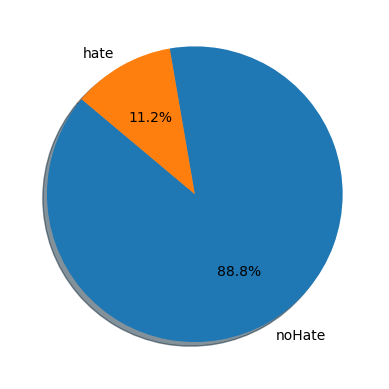

In [ ]:
sentiment_count=df_final["label"].value_counts()
plt.pie(sentiment_count, labels=sentiment_count.index,
         autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

**Unbalanced dataset**, it will be handled later


In [ ]:
df_final["label"].value_counts()

,count
label,
noHate,9507
hate,1196


##**TEXT NORMALIZATION**##

According to the literature... inserire testo

In [ ]:
stop_words=set(stopwords.words('english'))


In [ ]:
custom_stopwords = stop_words - {"not", "no"} #I'm keeping the negations to preserve the sentiment

In [ ]:
def normalize_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower().replace('’', "'")
    text = contractions.fix(text)

    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters except spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    doc = nlp(text)


    lemmatized_tokens = [token.lemma_ for token in doc]


    filtered_tokens = [word for word in lemmatized_tokens if word not in custom_stopwords]

    return ' '.join(filtered_tokens)

In [ ]:
df_final['Text'] = df_final['Text'].apply(normalize_text)
df_final.head()

<ipython-input-26-5111c4b0d8bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Text'] = df_final['Text'].apply(normalize_text)


,Text,label
0,please keep update result get,noHate
1,outraged presenter,noHate
2,I wish good,noHate
3,arrestant personal friend mean lot,noHate
4,may I ask describe typical georgian appearance,noHate


<function matplotlib.pyplot.show(close=None, block=None)>

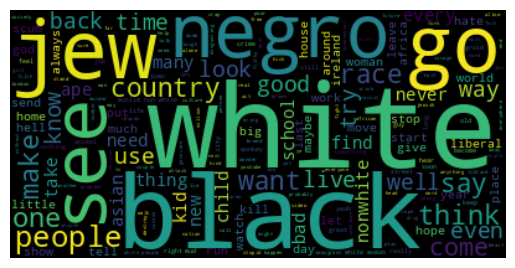

In [ ]:
neg_texts=df_final[df_final["label"]=="hate"]
txt=" ".join(text.lower() for text in neg_texts["Text"])
wordcloud=WordCloud().generate(txt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

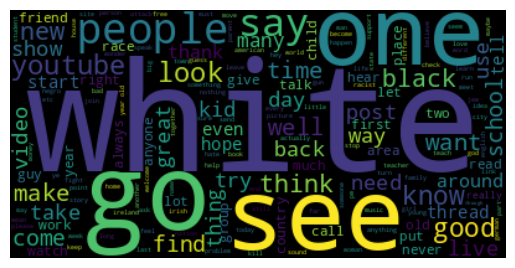

In [ ]:
pos_texts=df_final[df_final["label"]=="noHate"]
txt=" ".join(text.lower() for text in pos_texts["Text"])
wordcloud=WordCloud().generate(txt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show

In [ ]:
df_eda=df_final.copy()
df_eda['text_length'] = df_eda['Text'].apply(len)
df_eda['word_count'] = df_eda['Text'].apply(lambda x: len(x.split()))
df_eda['polarity'] = df_eda['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_eda['subjectivity'] = df_eda['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

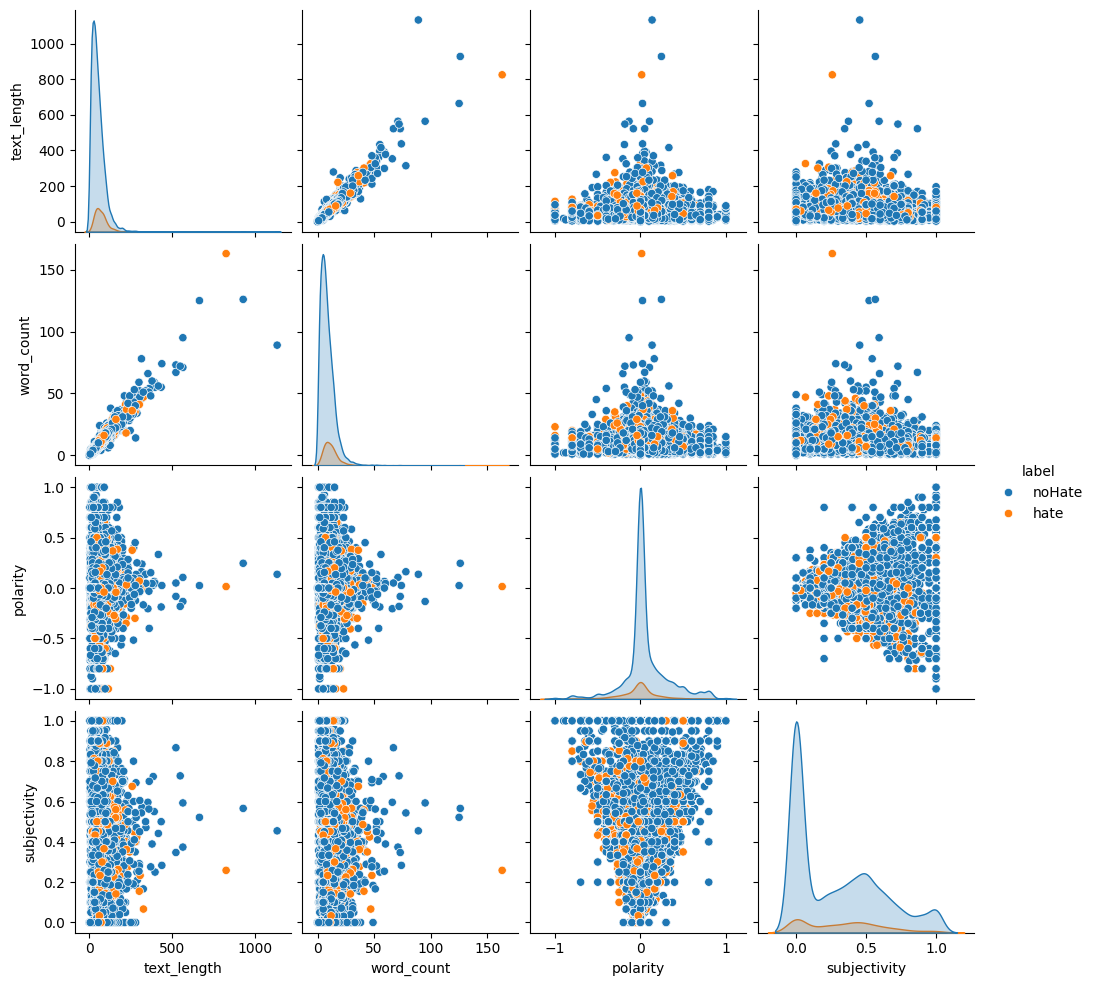

In [ ]:
sns.pairplot(
  df_eda[['text_length', 'word_count', 'polarity', 'subjectivity', 'label']],
  hue="label"
)

In [ ]:
df_final['label'] = df_final['label'].map({'hate': 1, 'noHate': 0})

<ipython-input-31-d43e0f52f473>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['label'] = df_final['label'].map({'hate': 1, 'noHate': 0})


In [ ]:
# Function to perform back translation
translator = Translator()

def back_translate(text, src_language='en', intermediate_language='de'):
    try:
        translated = translator.translate(text, src=src_language, dest=intermediate_language).text
        back_translated = translator.translate(translated, src=intermediate_language, dest=src_language).text
        return back_translated
    except Exception:

        return text

In [ ]:
hate_df = df_final[df_final['label'] == 1]
n_augmentations = 2
augmented_texts = []

for idx, row in hate_df.iterrows():
    for _ in range(n_augmentations):
        augmented_text = back_translate(row['Text'])
        augmented_texts.append({'Text': augmented_text, 'label': 1})


    time.sleep(0.1)


augmented_df = pd.DataFrame(augmented_texts)

df_final = pd.concat([df_final, augmented_df], ignore_index=True)

df_final = df_final.sample(frac=1).reset_index(drop=True)


print(df_final['label'].value_counts())

<ipython-input-36-6490b8858b73>:11: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text


label
0    9507
1    3588
Name: count, dtype: int64


In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_final['Text'])
feature_names = np.array(vectorizer.get_feature_names_out())

In [ ]:
hate_mask = df_final['label'] == 1
nohate_mask = df_final['label'] == 0

In [ ]:
hate_counts = np.asarray(X[hate_mask].sum(axis=0)).flatten()
nohate_counts = np.asarray(X[nohate_mask].sum(axis=0)).flatten()

data = {'Hate': hate_counts, 'NoHate': nohate_counts}
word_counts = pd.DataFrame(data, index=feature_names)

In [ ]:
word_counts['Total'] = word_counts['Hate'] + word_counts['NoHate']
word_counts = word_counts[word_counts['Total'] > 5]  # Filtro per evitare parole troppo rare

In [ ]:
total_hate = word_counts['Hate'].sum()
total_nohate = word_counts['NoHate'].sum()

In [ ]:
def log_likelihood(hate, nohate,total_hate,total_nohate):

  E_hate=(hate+nohate)*(total_hate/(total_hate+total_nohate))
  E_nohate= (hate+nohate)*(total_nohate/(total_hate+total_nohate))

  hate=max(hate,0.01)
  nohate=max(nohate,0.01)

  return 2 * (
        (hate * np.log(hate / E_hate)) + (nohate * np.log(nohate / E_nohate))
    ) if hate > nohate else -2 * (
        (hate * np.log(hate / E_hate)) + (nohate * np.log(nohate / E_nohate))
    )

In [ ]:
word_counts['log_likelihood'] = word_counts.apply(lambda row: log_likelihood(row['Hate'], row['NoHate'],total_hate,total_nohate), axis=1)


In [ ]:
word_counts['freq_diff'] = word_counts['Hate'] - word_counts['NoHate']

In [ ]:
word_counts

,Hate,NoHate,Total,log_likelihood,freq_diff
abandon,3,3,6,-0.458478,0
ability,0,8,8,-7.137075,-8
able,27,43,70,-0.136421,-16
abomination,3,3,6,-0.458478,0
abortion,12,5,17,8.163609,7
...,...,...,...,...,...
zionistengineered,6,1,7,7.279250,5
zog,15,2,17,19.783877,13
zombie,3,3,6,-0.458478,0
zone,6,5,11,1.487964,1


In [ ]:
most_hateful_words = word_counts[word_counts['freq_diff'] > 0].nlargest(10, 'log_likelihood').sort_values('log_likelihood', ascending=False)
most_nonhateful_words = word_counts[word_counts['freq_diff'] < 0].nsmallest(10, 'log_likelihood').sort_values('log_likelihood', ascending=True)

<ipython-input-48-d82e60cf2374>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='log_likelihood', y=most_hateful_words.index, data=most_hateful_words, ax=axes[0], palette='Reds')
<ipython-input-48-d82e60cf2374>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='log_likelihood', y=most_nonhateful_words.index, data=most_nonhateful_words, ax=axes[1], palette='Blues')


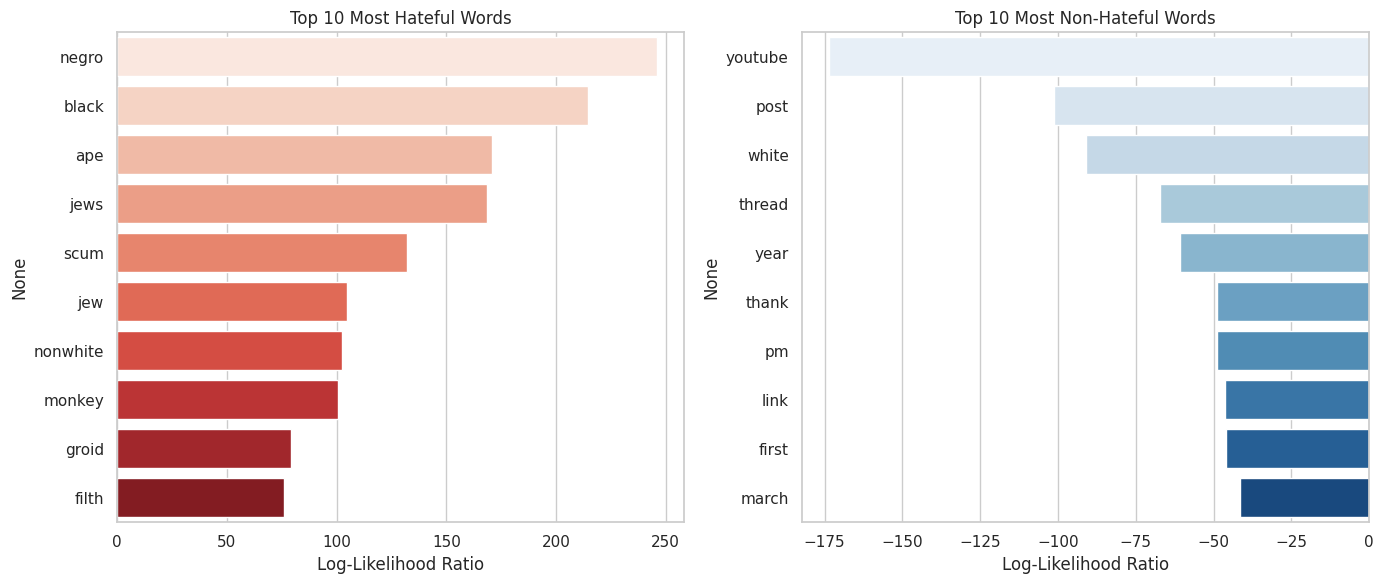

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x='log_likelihood', y=most_hateful_words.index, data=most_hateful_words, ax=axes[0], palette='Reds')
axes[0].set_title("Top 10 Most Hateful Words")
axes[0].set_xlabel("Log-Likelihood Ratio")

sns.barplot(x='log_likelihood', y=most_nonhateful_words.index, data=most_nonhateful_words, ax=axes[1], palette='Blues')
axes[1].set_title("Top 10 Most Non-Hateful Words")
axes[1].set_xlabel("Log-Likelihood Ratio")

plt.tight_layout()
plt.show()

## **Train and Test split**

In [ ]:
X=df_final['Text']
y=df_final['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [ ]:
X_train.shape[0]

10476

In [ ]:
X_test.shape[0]

2619

## Word tokenization

In [ ]:
tokenizer_full = Tokenizer(oov_token="<OOV>")
tokenizer_full.fit_on_texts(X_train)


word_counts = dict(tokenizer_full.word_counts)
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)


total_words = sum(word_counts.values())
cumulative_count, selected_vocab_size = 0, 0

for word, count in sorted_word_counts:
    cumulative_count += count
    selected_vocab_size += 1
    if cumulative_count / total_words >= 0.95:
        break

print(f"Suggested MAX_VOCAB_SIZE: {selected_vocab_size}")


Suggested MAX_VOCAB_SIZE: 6302


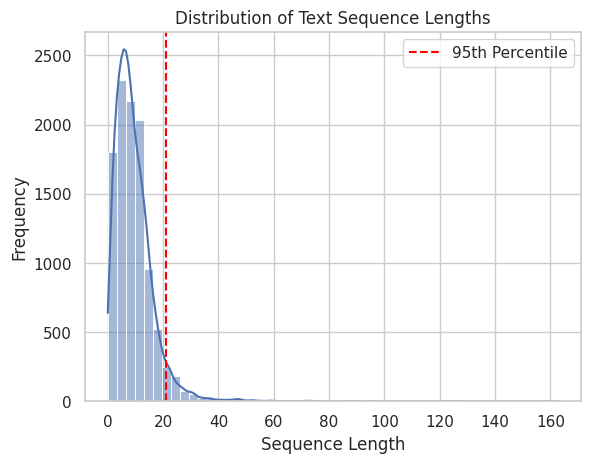

Suggested MAX_SEQUENCE_LENGTH: 21


In [ ]:
sequence_lengths = [len(seq) for seq in tokenizer_full.texts_to_sequences(X_train)]

sns.histplot(sequence_lengths, bins=50, kde=True)
plt.axvline(x=np.percentile(sequence_lengths, 95), color='red', linestyle='dashed', label="95th Percentile")
plt.legend()
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Sequence Lengths")
plt.show()

max_seq_length = int(np.percentile(sequence_lengths, 95))
print(f"Suggested MAX_SEQUENCE_LENGTH: {max_seq_length}")


In [ ]:
tokenizer = Tokenizer(num_words=selected_vocab_size, oov_token="<OOV>")

In [ ]:
tokenizer.fit_on_texts(X_train)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded_sequences = pad_sequences(train_sequences, maxlen=21, padding="post")


In [ ]:
train_padded_sequences.shape

(10476, 21)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded_sequences = pad_sequences(test_sequences, maxlen=21, padding="post")

In [ ]:
test_padded_sequences.shape

(2619, 21)

In [ ]:
index_words=tokenizer.word_index

In [ ]:
total_words = min(len(index_words)+1, selected_vocab_size)
print(total_words)

6302


# **MODEL IMPLEMENTATION**

## BASELINE BiLSTM MODEL

In [ ]:
#class weights to help for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
MAX_SEQ_LENGTH = 21
EMBEDDING_DIM = 100
LSTM_UNITS = 64
DROPOUT_RATE = 0.3
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
model_bilstm = Sequential([
    Input(shape=(MAX_SEQ_LENGTH,)),
    Embedding(input_dim=total_words, output_dim=EMBEDDING_DIM),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False)),
    Dropout(DROPOUT_RATE),
    Dense(32, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
model_bilstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 21, 100)        │       630,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 718,841 (2.74 MB)

 Trainable params: 718,841 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_bilstm = model_bilstm.fit(
    train_padded_sequences, y_train,
    validation_data=(test_padded_sequences, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7882 - loss: 0.4624 - val_accuracy: 0.8843 - val_loss: 0.3570
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9421 - loss: 0.1752 - val_accuracy: 0.9156 - val_loss: 0.2540
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9719 - loss: 0.0980 - val_accuracy: 0.9118 - val_loss: 0.3144
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9827 - loss: 0.0566 - val_accuracy: 0.9317 - val_loss: 0.1965
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9869 - loss: 0.0459 - val_accuracy: 0.9420 - val_loss: 0.2041
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9923 - loss: 0.0267 - val_accuracy: 0.9488 - val_loss: 0.2193
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9930 - loss: 0.0235 - val_accuracy: 0.9477 - val_loss: 0.2425
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9917 - loss: 0.0265 - val_accuracy:

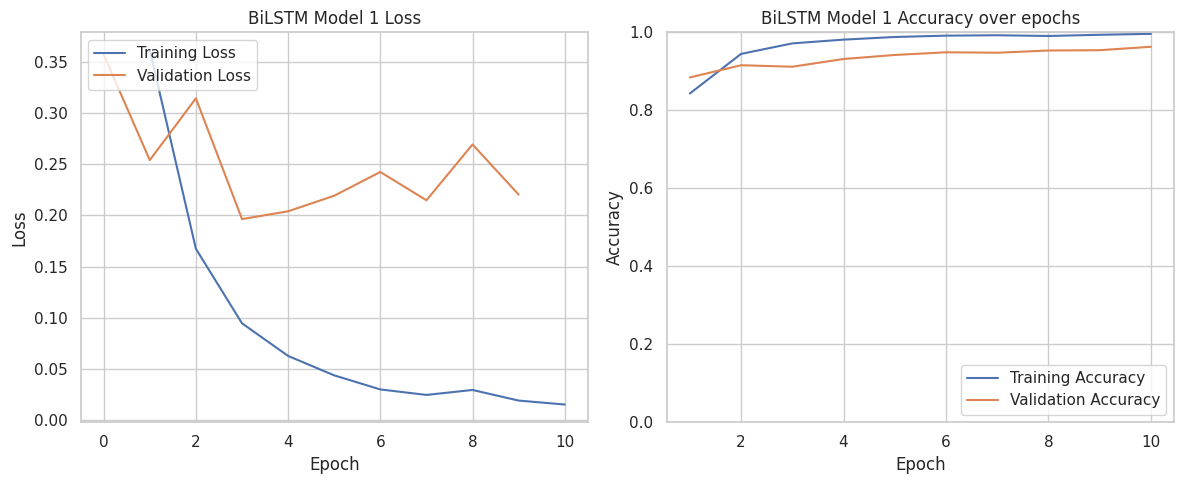

In [ ]:
plot_training_history(history_bilstm, range(1, EPOCHS + 1), title_prefix="BiLSTM Model 1")

Model clearly overfits, I add some regularization metrics to try to reduce it.

In [ ]:
model_bilstm_1 = Sequential([
    Input(shape=(MAX_SEQ_LENGTH,)),
    Embedding(input_dim=total_words, output_dim=EMBEDDING_DIM),
    Bidirectional(LSTM(16, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_bilstm_1.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_bilstm_1.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history_bilstm_1 = model_bilstm_1.fit(
    train_padded_sequences, y_train,
    validation_data=(test_padded_sequences, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 21, 100)        │       630,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,721 (2.46 MB)

 Trainable params: 645,721 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6837 - loss: 1.7625 - val_accuracy: 0.8282 - val_loss: 0.6186
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8485 - loss: 0.5787 - val_accuracy: 0.8690 - val_loss: 0.4282
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9298 - loss: 0.3309 - val_accuracy: 0.9045 - val_loss: 0.3651
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9604 - loss: 0.2331 - val_accuracy: 0.9187 - val_loss: 0.3074
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9690 - loss: 0.1995 - val_accuracy: 0.9317 - val_loss: 0.2845
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9795 - loss: 0.1503 - val_accuracy: 0.9332 - val_loss: 0.2668
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9810 - loss: 0.1429 - val_accuracy: 0.9404 - val_loss: 0.2480
Epoch 8/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9801 - loss: 0.1393 - val_accuracy:

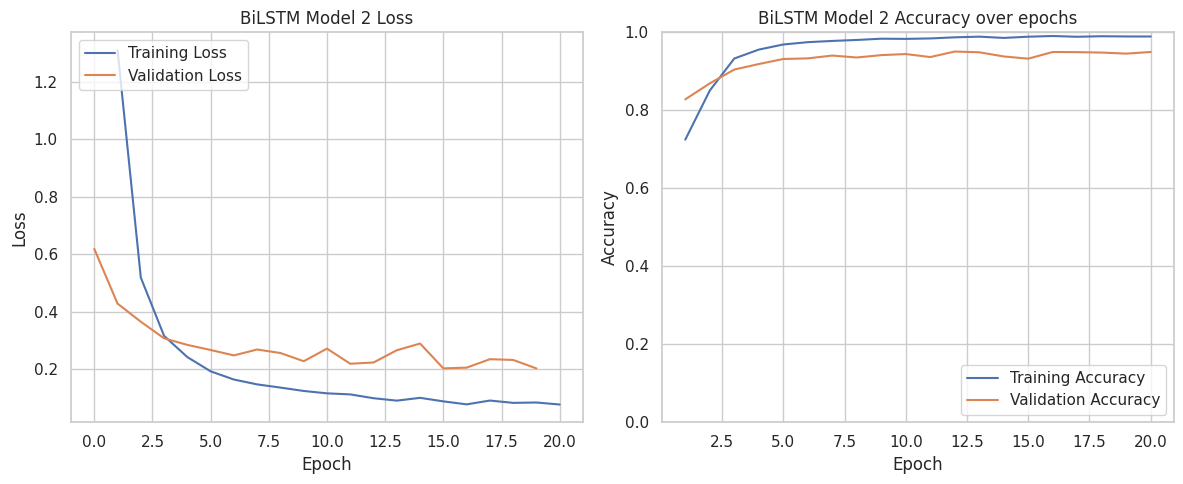

In [ ]:
plot_training_history(history_bilstm_1, range(1, 21), title_prefix="BiLSTM Model 2")

In [ ]:
corpus = [word_tokenize(sentence.lower()) for sentence in X_train]

In [ ]:
word2vec_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("custom_word2vec_100.model")

In [ ]:
word2vec_model = Word2Vec.load("custom_word2vec_100.model")


In [ ]:
def create_word2vec_embedding_matrix(word2vec_model, vocab_size, embedding_dim, word_index):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return embedding_matrix

embedding_matrix_word2vec = create_word2vec_embedding_matrix(word2vec_model, vocab_size=total_words, embedding_dim=100, word_index=index_words)

In [ ]:
glove_model = api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
def load_glove_embeddings(glove_model, vocab_size, embedding_dim, word_index):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
          continue
        if word in glove_model:
          embedding_matrix[i] = glove_model[word]
    return embedding_matrix

In [ ]:
embedding_matrix_glove = load_glove_embeddings(glove_model, vocab_size=total_words, embedding_dim=100, word_index=index_words)

Fast text embedding:

In [ ]:
fasttext_model =FastText(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def create_fasttext_embedding_matrix(fasttext_model, vocab_size, embedding_dim, word_index):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = fasttext_model.wv.get_vector(word, norm=True) if word in fasttext_model.wv else None
        if embedding_vector is not None:

            reduced_vector = embedding_vector[:embedding_dim]
            embedding_matrix[i] = reduced_vector
        else:

            embedding_matrix[i] = np.random.rand(embedding_dim)
    return embedding_matrix


In [ ]:
embedding_matrix_fasttext = create_fasttext_embedding_matrix(fasttext_model, vocab_size=total_words, embedding_dim=100, word_index=index_words)


Hyper model with also the embedding choice

In [ ]:
class BiLSTMHyperModel(HyperModel):
    def __init__(self, embedding_matrices):
        self.embedding_matrices = embedding_matrices

    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(MAX_SEQ_LENGTH,)))


        embedding_choice = hp.Choice('embedding_choice', ['word2vec', 'glove', 'fasttext'])
        if embedding_choice == 'word2vec':
            embedding_matrix = self.embedding_matrices['word2vec']
        elif embedding_choice == 'glove':
            embedding_matrix = self.embedding_matrices['glove']
        else:
            embedding_matrix = self.embedding_matrices['fasttext']

        model.add(Embedding(input_dim=total_words,
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False))

        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Bidirectional(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                                         return_sequences=(i < hp.Int('num_layers', 1, 3) - 1),
                                         kernel_regularizer=l2(hp.Float('l2', min_value=0.01, max_value=0.05, step=0.01)),
                                         activation='relu')))
            model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.6, step=0.1)))

        model.add(BatchNormalization())
        model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(hp.Float('dense_l2', min_value=0.01, max_value=0.05, step=0.01))))

        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model


In [ ]:
embedding_matrices = {
    'word2vec': embedding_matrix_word2vec,
    'glove': embedding_matrix_glove,
    'fasttext': embedding_matrix_fasttext
}


In [ ]:
import keras_tuner as kt
tuner = kt.BayesianOptimization(
    BiLSTMHyperModel(embedding_matrices),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='bilstm_tuning'
)

In [ ]:
tuner.search(train_padded_sequences, y_train, epochs=15, validation_data=(test_padded_sequences, y_test), class_weight=class_weight_dict)

Trial 10 Complete [00h 01m 21s]
val_accuracy: 0.7273768782615662

Best val_accuracy So Far: 0.8930889368057251
Total elapsed time: 00h 14m 12s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

embedding_choice: glove
num_layers: 3
lstm_units_0: 64
l2: 0.05
dropout: 0.30000000000000004
dense_l2: 0.02
learning_rate: 0.0001913706454695583
lstm_units_1: 64
lstm_units_2: 32


In [ ]:
model_tuned_bilstm = Sequential()
model_tuned_bilstm.add(Input(shape=(21,)))
model_tuned_bilstm.add(Embedding(input_dim=total_words,
                    output_dim=100,
                    weights=[embedding_matrix_glove],
                    trainable=False))

# First LSTM layer
model_tuned_bilstm.add(Bidirectional(LSTM(units=64,
                             return_sequences=True,
                             kernel_regularizer=l2(0.05),
                             activation='relu')))
model_tuned_bilstm.add(Bidirectional(LSTM(units=64,
                             return_sequences=True,
                             kernel_regularizer=l2(0.05),
                             activation='relu')))
model_tuned_bilstm.add(Bidirectional(LSTM(units=32,
                             return_sequences=False,
                             kernel_regularizer=l2(0.05),
                             activation='relu')))



model_tuned_bilstm.add(Dropout(0.30000000000000004))


model_tuned_bilstm.add(BatchNormalization())
model_tuned_bilstm.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.02)))

model_tuned_bilstm.compile(optimizer=Adam(learning_rate=0.0001913706454695583),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model_tuned_bilstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 21, 100)        │       630,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 21, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 21, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 855,033 (3.26 MB)

 Trainable params: 224,705 (877.75 KB)

 Non-trainable params: 630,328 (2.40 MB)

In [ ]:
history_tuned_bilstm = model_tuned_bilstm.fit(train_padded_sequences, y_train, epochs=15, validation_data=(test_padded_sequences, y_test), class_weight=class_weight_dict)

Epoch 1/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.6426 - loss: 33.4852 - val_accuracy: 0.7953 - val_loss: 11.3693
Epoch 2/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7610 - loss: 8.2505 - val_accuracy: 0.7835 - val_loss: 2.8247
Epoch 3/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7956 - loss: 2.1389 - val_accuracy: 0.8160 - val_loss: 0.9976
Epoch 4/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8105 - loss: 0.8746 - val_accuracy: 0.8358 - val_loss: 0.6171
Epoch 5/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8183 - loss: 0.6156 - val_accuracy: 0.7923 - val_loss: 0.6135
Epoch 6/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8381 - loss: 0.5213 - val_accuracy: 0.8522 - val_loss: 0.4745
Epoch 7/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8527 - loss: 0.4648 - val_accuracy: 0.8614 - val_loss: 0.4494
Epoch 8/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8573 - loss: 0.4387 - val_

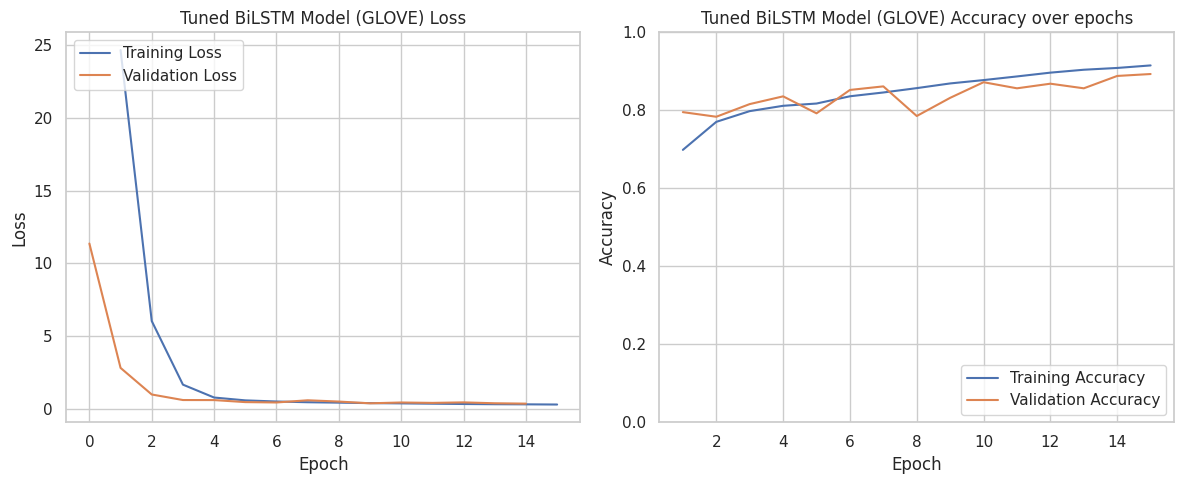

In [ ]:
plot_training_history(history_tuned_bilstm, range(1, 16), title_prefix="Tuned BiLSTM Model (GLOVE)")

# **Performance evaluation Bilstms models**

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, digits=4))

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [ ]:
evaluate_model(model_bilstm, test_padded_sequences, y_test, model_name="BiLSTM Model 1 (Baseline)")
evaluate_model(model_bilstm_1, test_padded_sequences, y_test, model_name="BiLSTM Model 2 (Regularized)")
evaluate_model(model_tuned_bilstm, test_padded_sequences, y_test, model_name="Tuned BiLSTM Model (GLOVE)")


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report for BiLSTM Model 1 (Baseline):
              precision    recall  f1-score   support

           0     0.9892    0.9595    0.9741      1901
           1     0.9006    0.9721    0.9350       718

    accuracy                         0.9630      2619
   macro avg     0.9449    0.9658    0.9546      2619
weighted avg     0.9649    0.9630    0.9634      2619

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report for BiLSTM Model 2 (Regularized):
              precision    recall  f1-score   support

           0     0.9773    0.9527    0.9648      1901
           1     0.8825    0.9415    0.9111       718

    accuracy                         0.9496      2619
   macro avg     0.9299    0.9471    0.9379      2619
weighted avg     0.9513    0.9496    0.9501      2619

82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step
Classification Report for Tuned BiLSTM Model (GLOVE):
              precision    recall  f1-score   support

          

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


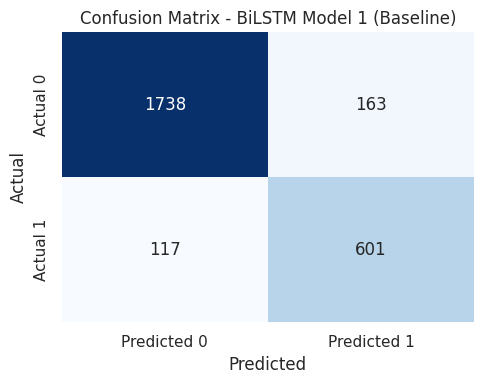

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


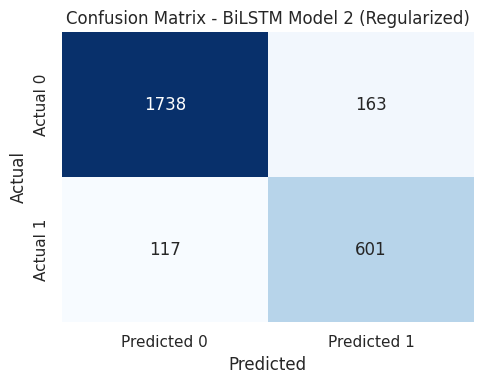

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


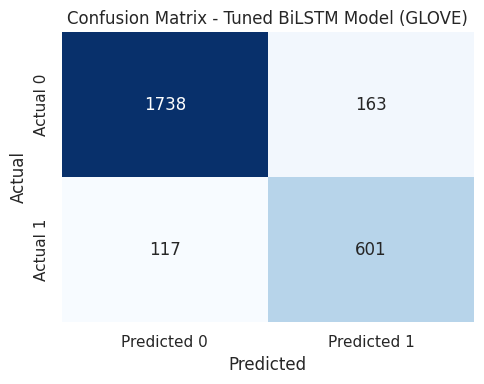

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, model_name="Model"):
    y_pred_probs = model_tuned_bilstm.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(model_bilstm, test_padded_sequences, y_test, model_name="BiLSTM Model 1 (Baseline)")
plot_confusion_matrix(model_bilstm_1, test_padded_sequences, y_test, model_name="BiLSTM Model 2 (Regularized)")
plot_confusion_matrix(model_tuned_bilstm, test_padded_sequences, y_test, model_name="Tuned BiLSTM Model (GLOVE)")


# **BERT MODEL**

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
train_df = X_train.to_frame(name="text")
train_df["label"] = y_train.astype(int)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
test_df = X_test.to_frame(name="text")
test_df["label"] = y_test.astype(int)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print("Train label distribution:", Counter(train_dataset["label"]))
print("Test label distribution:", Counter(test_dataset["label"]))

Train label distribution: Counter({0: 7606, 1: 2870})
Test label distribution: Counter({0: 1901, 1: 718})


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10476 [00:00<?, ? examples/s]

Map:   0%|          | 0/2619 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets ={
    "train": train_dataset,
    "test": test_dataset
}


labels = train_dataset["label"]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(tokenized_datasets["train"].shape)
print(tokenized_datasets["test"].shape)
print("Class weights:", class_weights)
print("Class weights:", class_weights)

(10476, 5)
(2619, 5)
Class weights: tensor([0.6887, 1.8251])
Class weights: tensor([0.6887, 1.8251])


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

#Freeze bottom 8 BERT encoder layers & embeddings

for param in model.bert.embeddings.parameters():
    param.requires_grad = False


for i in range(0, 8):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Trainable parameters: 28943618


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_epochs = 10
num_training_steps = num_epochs * len(tokenized_datasets["train"])
num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    fp16=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    warmup_ratio=0.1,
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    optimizers=(optimizer, lr_scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:645: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: beric-mina (beric-mina-universit-degli-studi-di-milano) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.673000,0.645916,0.603284,0.397313,0.864903,0.544498
2,0.508700,0.503208,0.745323,0.523416,0.793872,0.630880
3,0.467900,0.478727,0.802978,0.633245,0.668524,0.650407
4,0.402500,0.428458,0.822069,0.645833,0.777159,0.705436
5,0.386200,0.393544,0.835433,0.668625,0.792479,0.725303
6,0.365900,0.377009,0.813288,0.606512,0.908078,0.727273
7,0.304700,0.339902,0.846506,0.662887,0.895543,0.761848
8,0.276200,0.276234,0.886216,0.728261,0.933148,0.818071
9,0.224200,0.233007,0.910653,0.768293,0.965181,0.855556
10,0.189500,0.230634,0.932799,0.868207,0.889972,0.878955


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', a

TrainOutput(global_step=6550, training_loss=0.3894880814588707, metrics={'train_runtime': 915.4938, 'train_samples_per_second': 114.43, 'train_steps_per_second': 7.155, 'total_flos': 6890878539878400.0, 'train_loss': 0.3894880814588707, 'epoch': 10.0})

In [ ]:
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)


{'eval_loss': 0.2306339293718338, 'eval_accuracy': 0.9327987781596029, 'eval_precision': 0.8682065217391305, 'eval_recall': 0.8899721448467967, 'eval_f1': 0.8789546079779917, 'eval_runtime': 6.7349, 'eval_samples_per_second': 388.869, 'eval_steps_per_second': 24.351, 'epoch': 10.0}


# **Performance evaluation Bert model**

/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)


              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1901
           1       0.87      0.89      0.88       718

    accuracy                           0.93      2619
   macro avg       0.91      0.92      0.92      2619
weighted avg       0.93      0.93      0.93      2619



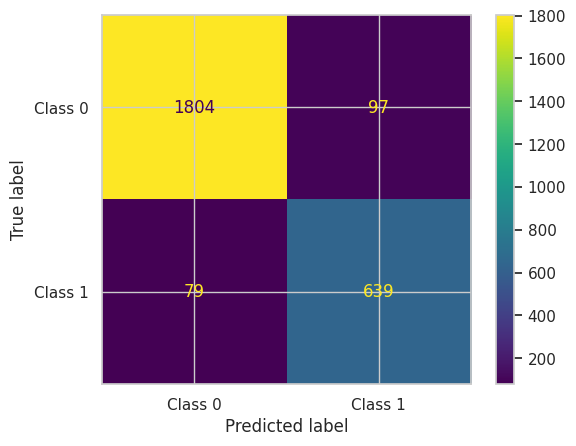

In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

print(classification_report(tokenized_datasets["test"]["label"], predicted_labels))

cm = confusion_matrix(tokenized_datasets["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [ ]:
y_pred = (predicted_labels > 0.5).astype("int32")

misclassified_mask = (y_pred.flatten() != tokenized_datasets["test"]["label"])


misclassified_text = X_test[misclassified_mask]
misclassified_true_labels = y_test[misclassified_mask]
misclassified_pred_labels = y_pred.flatten()[misclassified_mask]


misclassified_df = pd.DataFrame({
    'Misclassified Text': misclassified_text,
    'True Label': misclassified_true_labels,
    'Predicted Label': misclassified_pred_labels
})


misclassified_sample = misclassified_df.head(5)


for _, row in misclassified_sample.iterrows():
    print(f"Misclassified Text: {row['Misclassified Text']}")
    print(f"True Label: {row['True Label']}")
    print(f"Predicted Label: {row['Predicted Label']}")
    print("-" * 80)

Misclassified Text: jews medium never report incident kind incident like everwake white people black white crime problem go get lot bad
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------------------
Misclassified Text: no I mean get around buy land ple choose town refuse nonwhite buy property area probably would not matter nonwhite buy house join ple
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------------------
Misclassified Text: get tougether save great race
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------------------
Misclassified Text: regime want german hate bad not already brown muslim
True Label: 1
Predicted Label: 0
--------------------------------------------------------------------------------
Misclassified Text: mein kampf no never say anything kill every jew earth like jews claim want
True Label: 0
Predicted Label: 1
---

In [ ]:
#TEST BERT MODEL WITH NEW EXAMPLES
def predict_post(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=-1).item()

    labels = ['Class 0', 'Class 1']
    return labels[pred_label]

texts = [
    'happy',
    'nigga',
    "Shut up dirty faggot",
]

for text in texts:
    print(f"Text: {text} - Predicted Label: {predict_post(text)}")

results = trainer.evaluate()
print(results)

Text: happy - Predicted Label: Class 0
Text: nigga - Predicted Label: Class 1
Text: Shut up dirty faggot - Predicted Label: Class 0


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)


{'eval_loss': 0.2306339293718338, 'eval_accuracy': 0.9327987781596029, 'eval_precision': 0.8682065217391305, 'eval_recall': 0.8899721448467967, 'eval_f1': 0.8789546079779917, 'eval_runtime': 6.9689, 'eval_samples_per_second': 375.812, 'eval_steps_per_second': 23.533, 'epoch': 10.0}
